# Detector Response Tests

Demonstrate the conversion of neutrino flux at Earth to observed hits in IceCube.

In [1]:
%matplotlib inline

from asteria import config, source, detector #, interactions
from asteria.neutrino import Flavor
from asteria.interactions import Interactions
from asteria.oscillation import SimpleMixing
from asteria.config import parse_quantity
import asteria.IO as io

import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Setup styles for Plotting

In [2]:
axes_style =   {            'grid' : 'True',
                       'labelsize' : '24',
                        'labelpad' : '8.0' }

xtick_style =  {       'direction' : 'out',
                       'labelsize' : '20.',
                      'major.size' : '5.',   
                     'major.width' : '1.',
                   'minor.visible' : 'True',
                      'minor.size' : '2.5',
                     'minor.width' : '1.' }

ytick_style =  {       'direction' : 'out',
                       'labelsize' : '20.',
                      'major.size' : '5',   
                     'major.width' : '1.',
                   'minor.visible' : 'True',
                      'minor.size' : '2.5',
                     'minor.width' : '1.' }

grid_style =   {           'alpha' : '0.75' }
legend_style = {        'fontsize' : '18' }
font_syle =    {            'size' : '20'}
text_style =   {          'usetex' : 'True' }
figure_style = {  'subplot.hspace' : '0.05' }

mpl.rc(    'font', **font_syle )
mpl.rc(    'text', **text_style )
mpl.rc(    'axes', **axes_style )
mpl.rc(   'xtick', **xtick_style )
mpl.rc(   'ytick', **ytick_style )
mpl.rc(    'grid', **grid_style )
mpl.rc(  'legend', **legend_style )
mpl.rc(  'figure', **figure_style )

mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']

## Load Configuration

This will load the source configuration from a file.

For this to work, either the user needs to have done one of two things:
1. Run `python setup.py install` in the ASTERIA directory.
2. Run `python setup.py develop` and set the environment variable `ASTERIA` to point to the git source checkout.

If these were not done, the initialization will fail because the paths will not be correctly resolved.

In [3]:
conf = config.load_config('../../data/config/default.yaml')
ccsn = source.initialize(conf)
i3 = detector.initialize(conf)

## Prepare Iterables

Define the range of neutrino energies (`E_nu`) to simulate and the times (`time`) at which to perform the simulation. 

In [4]:
# Define neutrino energy spectrum
E_min = parse_quantity(conf.simulation.energy.min).to(u.MeV).value
E_max = parse_quantity(conf.simulation.energy.max).to(u.MeV).value 
dE = parse_quantity(conf.simulation.energy.step).to(u.MeV).value
Enu = np.arange(E_min, E_max+dE, dE) * u.MeV

# Define post-bounce times at which to evaluate
t_min = parse_quantity(conf.simulation.time.min).to(u.s).value
t_max = parse_quantity(conf.simulation.time.max).to(u.s).value 
dt = parse_quantity(conf.simulation.time.step).to(u.s).value
time = np.arange(t_min, t_max+dt, dt) * u.s

## Compute Charged Particle Spectrum

Compute the number of photons produced by $\nu$ component interactions with charged particles given neutrino flavor and energy. `Interactions` contains a list of the interactions that are simulated. This list may be changed to turn 'off/on' specific interactions

The interactions are as follows:
- `InvBetaTab` : Tabulated inverse beta decay computation by Strumia and Vissani, Phys. Lett. B 564:42, 2003.
  - See Also: `InvBetaPar` : Inverse beta decay parameterization
- `ElectronScatter` : Elastic Neutrino-electron scattering from Marciano and Parsa, J. Phys. G 29:2969, 2003.
- `Oxygen16CC` : $\nu$-$^{16}O$ charged current interaction, using estimates from Kolbe et al., PRD 66:013007, 2002.
- `Oxygen16NC` : $\nu$-$^{16}O$ neutral current interaction, using estimates from Kolbe et al., PRD 66:013007, 2002.
- `Oxygen18` : $\nu$-$^{18}O$ charged current interaction, using estimates from Kamiokande data from Haxton and Robertson, PRC 59:515, 1999.

These `Interaction` objects may be used to compute the neutrino cross sections and mean energy of the produced lepton, both as a function of neutrino energy. The final state lepton energy has been integrated out. This cross section with a component of $H_2O$ is then scaled as appropriate for a $H_2O$ molecule (IE Electron scattering cross section is scaled by 10, as there are 10 electrons in $H_2O$).

`photon_scaling_factor` is the number of photones per MeV of lepton energy. It is computed by taking product of the data members `photons_per_lepton_MeV` and `p2e_path_ratio` which are respectively, the number of photons emitted per unit lepton path length, and the ratio of positron path length to electron path length in ice.

`photons_per_lepton_MeV` is computed by finding number of photon emitted per unit lepton path length and multiplying it by the lepton path length per MeV. This is done using the Frank-Tamm formula and index of refraction from Price and Bergstrom, AO 36:004181, 1997.

This result estimates the number of photons as a function of neutrino energy. It will have units $m^2$ at the end of this cell but is later scaled by a factor of $r^2$ where $r$ is the progenitor distance, to account for the neutrinos spreading out as they travel.

In [5]:
photon_spectra = np.zeros( shape=(len(Flavor), Enu.size) )

for nu, flavor in enumerate(Flavor):
    for interaction in Interactions: 
        xs    = interaction.cross_section(flavor, Enu).to(u.m**2).value
        E_lep = interaction.mean_lepton_energy(flavor, Enu).value
        photon_scaling_factor = interaction.photon_scaling_factor(flavor).to( 1/u.MeV).value
        
        
        photon_spectra[nu] +=  xs * E_lep * photon_scaling_factor # u.m**2 
    
photon_spectra *= u.m**2 

## Compute Signal per DOM

For each flavor, compute the photonic energy deposition in one $m^3$ of ice, and then scale it to the effective volume of one DOM.

`photonic_energy_per_ performs the simulation utilizing numpy broadcasting, and not iteration.

1. Compute the neutrino spectrum from the model Luminosity $L$, Mean neutrino energy $\left< E \right>$ and pinch parameter $\alpha$, which are specified in the SN spectrum file chosen by `config`. This spectrum is a gamma-like p.d.f. of neutrino energy, computed for every time step in `time`. 

2. Multiply the neutrino spectrum and photon spectrum, which are both functions of neutrino energy, then numerically integrate over neutrino energies. This is computed for every time step in `time`.

3. Scale the result of the numerical integration by the neutrino flux and divide by $r^2$ to obtain the photon energy deposition per $m^3$.

This result of `photonic_energy_per_vol` is scaled to the effective volume of a DOM to find the expected signal increase in a single DOM.

In [6]:
E_per_V = np.zeros( shape=(len(Flavor), time.size) ) * u.MeV / u.m**3
total_E_per_V = np.zeros( time.size ) * u.MeV / u.m**3

mixing = None
if conf.simulation.hierarchy == 'normal':
    mixing = SimpleMixing(33.2).normal_mixing
elif conf.simulation.hierarchy == 'inverted':
    mixing = SimpleMixing(33.2).inverted_mixing
        
icecube_dt = 2e-3 #s

effvol = 0.1654 * u.m**3 / u.MeV #Simple estimation of IceCube DOM Eff. Vol.

for nu, (flavor, photon_spectrum) in enumerate(zip(Flavor, photon_spectra)):
    E_per_V[nu] = ccsn.photonic_energy_per_vol(time, Enu, flavor, photon_spectrum, mixing)
    total_E_per_V += E_per_V[nu]

signal_per_DOM = effvol * E_per_V 

Beginning nu_e simulation...       Completed
Beginning nu_e_bar simulation...   Completed
Beginning nu_x simulation...       Completed
Beginning nu_x_bar simulation...   Completed


## Save Simulation to File

The photonic energy per volume is the quantity that is most computationally difficult to obtain, and can be used to obtain numerous high level results. Saving this information to file enables faster processing for large scale analysis. Using `IO.save` the energy per volume is stored in the file `\data\processed\nakazato-shen-z0.02-t_rev300ms-s13.0.h5`, the path to which is stored in `conf`.

The result is scaled to a progenitor that is 1 kpc away. See the file `\docs\nb\load_simulation.ipynb` for information on reading the simulation result from file.

__NOTE__: If the a simulation with the same configuration already exists in`\data\processed\nakazato-shen-z0.02-t_rev300ms-s13.0.h5`, trying to save the simulation will cause `io.save` to throw an exception, which is handled in-line with a `try`/`except` block. This may be bypassed by using

```io.save(conf, E_per_V_1kpc, force=True)```

In [7]:
E_per_V_1kpc =  E_per_V * ccsn.progenitor_distance.to(u.kpc).value**2
try:
    io.save(conf, E_per_V_1kpc)
except FileExistsError as e:
    print(e)

Found  0
Simulation exists, Aborting. Use argument 'force = True' to force saving.


## Define Helper Functions

Define Functions for plotting, retrieving information from ROOT Files

- `rebin` Reshape the independent variable `var` with resolution `old_binning` and dependent variable `data` (assumed to be numpy array) and return new arrays `var` and `data` with resolution `new_binning`.

- `bin_hits` using the `detector` table of DOMs and their properties, determines the number of hits within the specified binning `binning`. This takes into account the artificial deadtime of the DOMs.




In [8]:
def rebin(var, data, old_binning, new_binning):
    step = int(new_binning/old_binning)
    new_size = int(data.size / step)
    rebinned_data = np.array([np.sum(data_part) for data_part in np.array_split( data, new_size )])
    rebinned_var  = var.value[int(0.5 * step)::step]
    
    return rebinned_var, rebinned_data  

def bin_hits(detector, time, total_E_per_V, dt, binning):
    doms = detector.doms_table()
    n_i3_doms = len(doms[doms['type'] == 'i3'])
    n_dc_doms = len(doms[doms['type'] == 'dc'])

    deadtime = detector.deadtime
    dc_rel_eff = detector.dc_rel_eff

    i3_dom_bg_mu = detector.i3_dom_bg_mu
    i3_dom_bg_sig = detector.i3_dom_bg_sig

    dc_dom_bg_mu = detector.dc_dom_bg_mu
    dc_dom_bg_sig = detector.dc_dom_bg_sig
    
    time_binned, total_E_per_V_binned = rebin(time, total_E_per_V, dt, binning)
    eps_i3 = 0.87 / (1+deadtime*total_E_per_V_binned/binning)
    eps_dc = 0.87 / (1+deadtime*total_E_per_V_binned*dc_rel_eff/binning)
    hits_binned = i3.detector_hits(total_E_per_V_binned, eps_i3, eps_dc)

    sn_bg_mu  = (n_i3_doms*i3_dom_bg_mu + n_dc_doms*dc_dom_bg_mu ) * binning;
    sn_bg_sig = np.sqrt( (n_i3_doms*i3_dom_bg_sig**2 + n_dc_doms*dc_dom_bg_sig**2) * binning )
    bg_binned = np.random.normal(sn_bg_mu, sn_bg_sig, time_binned.size)
   
    return time_binned, bg_binned, hits_binned

## Plot Expected Signal Increase for Each Flavor
This will plot the signal increase in a single DOM caused by each flavor. The curve shows the DOM response from 0.05 seconds before the core bounce to 0.65 seconds after the core bounce. Note that this is computed with the assumption that the effective volume of the DOM is 0.1654 m$^3$ MeV$^{-1}$

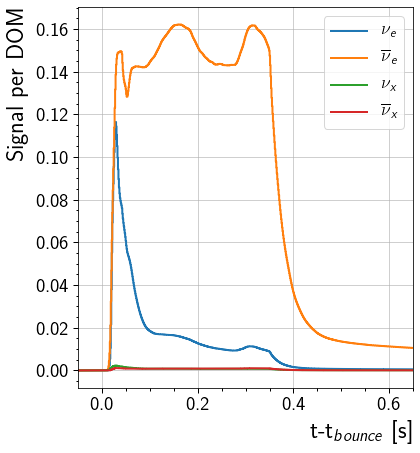

In [9]:
fig, ax = plt.subplots(1, figsize = (6,7))

for nu, flavor in enumerate(Flavor):
    ax.step( time, signal_per_DOM[nu], label=flavor.to_tex(), linewidth=2)
    
ax.set_ylabel( 'Signal per DOM', horizontalalignment='right', y = 1)
ax.set_xlabel(r't-t$_{bounce}$ [s]', horizontalalignment='right', x=1.0)
ax.set(xlim=(-0.05, 0.65))
ax.legend()

## Plot Expected Signal Increase in Detector
This will plot the signal increase across the entire detector. The curve shows the DOM response from 0.05 seconds before the core bounce to 0.65 seconds after the core bounce.

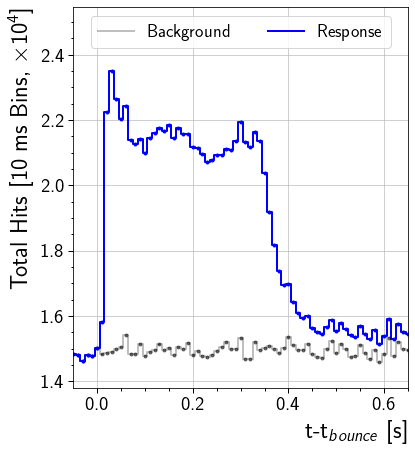

In [10]:
sn_dt = 0.01 #Units seconds: 10ms binning for plotting
time_binned, bg_binned, signal_binned = bin_hits(i3, time, total_E_per_V.value, dt, sn_dt)

# Scaled to improve readability of axis labels
background = bg_binned/1e4
signal = signal_binned/1e4
response = background+signal

fig, ax = plt.subplots(1, figsize = (6,7))
ax.step(time_binned, background , lw=2, label='Background', color='k', alpha=0.25)[0] 
h = ax.step(time_binned, response, lw=2, label='Response', color='b')[0]  
# Error bars are computed on unscaled quantity and then scaled.
ax.errorbar(time_binned - 0.5*sn_dt, background, yerr=np.sqrt(background)/1e4, color='k', alpha=0.5, fmt='.')
ax.errorbar(time_binned - 0.5*sn_dt, response, yerr=np.sqrt(response)/1e4, color=h.get_color(), fmt='.')

ylimits = ax.get_ylim()
ax.set(xlim=(-0.05, 0.65), ylim=(ylimits[0], ylimits[1]+0.15))
ax.set_xlabel(r't-t$_{bounce}$ [s]', horizontalalignment='right', x=1.0)
ax.set_ylabel(r'Total Hits [10 ms Bins, $\times 10^4$]', horizontalalignment='right', y=1.0)
l = ax.legend(loc='upper center', ncol=2)